In [2]:
%load_ext autoreload
%autoreload 2
from model.model_AMD import AMDModel
from model import get_attention_maps, clear_attention_maps, set_vis_atten_flag
from safetensors.torch import load_model
from diffusers.models import AutoencoderKL
from dataset.dataset import AMDConsecutiveVideoDoubleRefBalance
from torch.utils.data import DataLoader
import torch
from model.utils import find_latest_checkpoint, save_cfg, vae_encode, vae_decode, freeze, print_param_num, model_load_pretrain, save_videos_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid 
import numpy as np

set_vis_atten_flag(True)

amd_config = '/mnt/pfs-gv8sxa/tts/dhg/zqy/iccvexp/amd_ablation/amd-s-t1-d512-doubleref-mask/config.json'
amd_ckpt = "/mnt/pfs-gv8sxa/tts/dhg/zqy/iccvexp/amd_ablation/amd-s-t1-d512-doubleref-mask/checkpoints" 
# '/mnt/pfs-mc0p4k/tts/team/digital_avatar_group/sunwenzhang/qiyuan/exp/newexp/amd_ablation/amd-s-t1-d512-doubleref-ablation/checkpoints'

amd_ckpt = find_latest_checkpoint(amd_ckpt)
amd_model = AMDModel.from_config(AMDModel.load_config(amd_config)).requires_grad_(False)
load_model(amd_model,amd_ckpt)
vae_version = '/mnt/pfs-gv8sxa/tts/dhg/zqy/model/sd-vae-ft-mse'
vae = AutoencoderKL.from_pretrained(vae_version, subfolder="vae").requires_grad_(False)
datapath = "/mnt/pfs-gv8sxa/tts/dhg/zqy/code/AMD2/dataset/txt/train_data_amd_hdtf.txt"
dataset = AMDConsecutiveVideoDoubleRefBalance(
    video_dir=datapath,
    ref_drop_ratio=0.0,
    sample_size=256,
    sample_stride=1,
    sample_n_frames=16
)

dataloader = DataLoader(dataset, batch_size=1,num_workers=0, shuffle=True, collate_fn=dataset.collate_fn,pin_memory=True)
device = torch.device("cuda:1")
dtype = torch.float32
amd_model = amd_model.to(device=device, dtype=dtype)
vae = vae.to(device, dtype)
cnt = 0


/mnt/pfs-gv8sxa/tts/dhg/wenzhangsun/.sun/envs/zqy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total 4411 !!!


100%|██████████| 4411/4411 [00:00<00:00, 1058353.35it/s]

Total 4411 files is available
4411


In [ ]:
from model.utils import display_images
for d in dataloader:
    name = d['name']
    video = d["videos"].to(device=device, dtype=dtype)
    ref_img = d["ref_img"].to(device=device, dtype=dtype)
    randomref_img = d["randomref_img"].to(device=device, dtype=dtype)
    cnt = cnt + 1
    break
print(name)
print(video.shape)
print(ref_img.shape)
print(randomref_img.shape)
# display_images(video,"/mnt/pfs-gv8sxa/tts/dhg/zqy/code/AMD2/sample/temp")
clear_attention_maps()
with torch.no_grad():
    z = vae_encode(vae,video) # N,T,c,h,w
    ref_img = vae_encode(vae,ref_img) # N,C,H,W
    randomref_img = vae_encode(vae,randomref_img) if randomref_img is not None else None
    time_step = torch.ones(size=(1,),device=device) * 1000
    pre,gt,loss_dict = amd_model(z,ref_img,randomref_img=randomref_img,mask_ratio=0, time_step=time_step)   
    loss = loss_dict['loss']
print(loss)
attention_maps = get_attention_maps()
print(len(attention_maps))
for i in range(len(attention_maps)):
    attention_maps[i] = attention_maps[i].mean(dim=1) # mean all head
    # attention_maps[i] = attention_maps[i].max(dim=1).values
    print(attention_maps[i].shape)
for l in range(12):
    motion_img = attention_maps[l][:, -1:, :256].reshape(-1, 256)
    motion_img = motion_img.reshape(-1, 1, 16, 16)
    motion_img = F.interpolate(motion_img, size=(256, 256), mode='bilinear')
    motion_img = make_grid(motion_img, nrow=16,padding=0, normalize=True).permute(1, 2, 0)
    cmap = plt.get_cmap("jet")
    motion_img = cmap(motion_img.cpu().numpy()[...,0])[..., :3]
    # fig = plt.figure(figsize=(160, 10))
    # ax = fig.add_subplot(111)
    # ax.imshow(motion_img.cpu().numpy(), cmap="viridis") # first fram
    video_grid = make_grid(video[0], nrow=16, padding=0).permute(1, 2, 0) / 2 + 0.5
    video_grid = video_grid.cpu().numpy()
    # fig = plt.figure(figsize=(160, 10))
    # ax = fig.add_subplot(111)
    # ax.imshow(video_grid.cpu().numpy() ) # first frame

    weighted_video_grid = np.clip(0.4 * video_grid + 0.6 * motion_img, 0,1)
    plt.imsave(f"/mnt/pfs-gv8sxa/tts/dhg/zqy/code/AMD2/demo/attn_maps/{cnt}_{l}.png",weighted_video_grid)
    # fig = plt.figure(figsize=(160, 10))
    # ax = fig.add_subplot(111)
    # ax.imshow(weighted_video_grid) # first frame

In [ ]:

last_attention_map = attention_maps[-1]
# for am in last_attention_map:

for am in attention_maps:
    motion_img = am[:, -4:, :256].reshape(-1, 256)
    motion_img = motion_img.reshape(-1, 1, 16, 16)
    # print(motion_img)
    motion_img = F.interpolate(motion_img, size=(256, 256), mode='bilinear')
    motion_img = make_grid(motion_img, nrow=4, normalize=True).permute(1, 2, 0)
    print(motion_img.shape)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.imshow(motion_img.cpu().numpy(), cmap="viridis") # first frame

In [3]:
def save_img(video_tensor:torch.Tensor,output_path, num_frames=4):
    # F C H W
    f, c, h, w = video_tensor.shape
    video_tensor = torch.clamp((video_tensor.detach().cpu() / 2 + 0.5) * 255, 0, 255).to(dtype=torch.uint8).numpy()
    video_tensor = video_tensor[:num_frames]
    video_tensor = video_tensor.transpose(2,0, 3, 1).reshape(h, num_frames * w, c)
    plt.imsave(output_path, video_tensor)
def sample_and_save(amd_model, vae, ref_img, randomref_img, motion, output_path, num_frames):

    # _, pred, _ = amd_model.sample(z, ref_img, randomref_img=randomref_img, mask_ratio=0)
    _, pred, _ = amd_model.sample_with_refimg_motion(ref_img = ref_img,
                                                    motion = motion,
                                                    randomref_img = randomref_img,
                                                    sample_step=20) # n f d h w 
    pred = vae_decode(vae, pred)
    save_img(pred[0], output_path, num_frames)

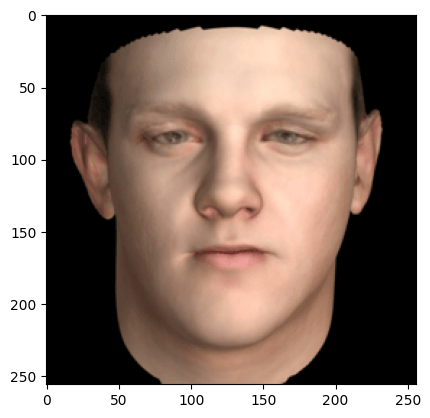

In [4]:
from torchvision.io import read_image
from torchvision.io.image import ImageReadMode
from torchvision.transforms import functional as F
bfm_img = read_image("/mnt/pfs-gv8sxa/tts/dhg/zqy/code/AMD2/demo/head.png", mode=ImageReadMode.RGB)
bfm_img = F.resize(bfm_img, (256, 256)) / 255.0
plt.imshow(bfm_img.permute(1, 2, 0))    
bfm_img = F.normalize(bfm_img, .5, .5)
bfm_img = bfm_img.unsqueeze(0).to(device=device, dtype=dtype)
bfm_img = vae_encode(vae, bfm_img)

In [5]:
amd_config_wo_mask = '/mnt/pfs-mc0p4k/tts/team/digital_avatar_group/sunwenzhang/qiyuan/exp/newexp/amd_ablation/amd-s-t1-d512-doubleref-ablation/config.json'
amd_ckpt_wo_mask = "/mnt/pfs-mc0p4k/tts/team/digital_avatar_group/sunwenzhang/qiyuan/exp/newexp/amd_ablation/amd-s-t1-d512-doubleref-ablation/checkpoints" 
amd_ckpt_wo_mask = find_latest_checkpoint(amd_ckpt_wo_mask)
amd_model_wo_mask = AMDModel.from_config(AMDModel.load_config(amd_config_wo_mask)).requires_grad_(False)
load_model(amd_model_wo_mask,amd_ckpt_wo_mask)
amd_model_wo_mask = amd_model_wo_mask.to(device=device, dtype=dtype)

In [28]:
r_cnt = 0
generator = torch.Generator()
generator.manual_seed(42)
r_dataloader = DataLoader(dataset, batch_size=2,num_workers=0, shuffle=False, collate_fn=dataset.collate_fn,pin_memory=True, generator=generator)

In [29]:
for d in r_dataloader:
    r_name = d['name']
    r_video = d["videos"][:1].to(device=device, dtype=dtype)
    r_ref_img = d["ref_img"].to(device=device, dtype=dtype)
    r_randomref_img = d["randomref_img"].to(device=device, dtype=dtype)
    r_cnt = r_cnt + 1
    break


In [46]:
d0 = dataset[1]
d1 = dataset[2]

In [47]:
# r_name = torch.stack([dataset[0]['name']])

r_video = d0["videos"].unsqueeze(0).to(device=device, dtype=dtype)
r_ref_img = torch.stack([ d0["ref_img"], d1["ref_img"]], dim=0).to(device=device, dtype=dtype)
r_randomref_img = torch.stack([d0["randomref_img"], d1["randomref_img"]],dim=0).to(device=device, dtype=dtype)
print(r_video.shape)

torch.Size([1, 16, 3, 256, 256])


In [52]:
r_cnt = 1
mask_ratio = 0
output_dir = f"/mnt/pfs-gv8sxa/tts/dhg/zqy/code/AMD2/demo/subtitution_mask{mask_ratio}"
set_vis_atten_flag(False)
z_vid = vae_encode(vae, r_video)
with torch.no_grad():
    ref_motion_wmask = amd_model.extract_motion(z_vid, mask_ratio=mask_ratio / 100.0) # n,f,l,d
    ref_motion_womask = amd_model_wo_mask.extract_motion(z_vid)

ref_img_origin = vae_encode(vae,r_ref_img[:1,0])
ref_img_sub = vae_encode(vae,r_ref_img[-1:,0])
randomref_img_origin = vae_encode(vae,r_randomref_img[:1,0])
randomref_img_sub = vae_encode(vae,r_randomref_img[-1:,0])

save_img(r_video[0], f"{output_dir}/motion_{r_cnt}.png", 16)
save_img(r_ref_img[:1,0], f"{output_dir}/origin_{r_cnt}.png", 1)
save_img(r_ref_img[-1:,0], f"{output_dir}/sub_{r_cnt}.png", 1)

sample_and_save(amd_model, vae,  ref_img_origin, randomref_img_origin, ref_motion_wmask, f"{output_dir}/origin_{r_cnt}_mask.png", 16)
sample_and_save(amd_model, vae,  ref_img_sub, randomref_img_sub, ref_motion_wmask, f"{output_dir}/sub_{r_cnt}_mask.png", 16)

sample_and_save(amd_model_wo_mask, vae,  ref_img_origin, randomref_img_origin, ref_motion_womask, f"{output_dir}/origin_{r_cnt}_wo_mask.png", 16)
sample_and_save(amd_model_wo_mask, vae,  ref_img_sub, randomref_img_sub, ref_motion_womask, f"{output_dir}/sub_{r_cnt}_wo_mask.png", 16)
# sample_and_show(amd_model, vae,  ref_img, torch.zeros_like(randomref_img), ref_motion)
# sample_and_show(amd_model, vae,  torch.zeros_like(ref_img), randomref_img, ref_motion)
# sample_and_show(amd_model, vae,  torch.zeros_like(ref_img), torch.zeros_like(randomref_img), ref_motion)



* Warnning * diffusion_model_type:doubleref


100%|██████████| 20/20 [00:01<00:00, 10.73it/s]


* Warnning * diffusion_model_type:doubleref


100%|██████████| 20/20 [00:01<00:00, 10.68it/s]


* Warnning * diffusion_model_type:doubleref


100%|██████████| 20/20 [00:01<00:00, 10.78it/s]


* Warnning * diffusion_model_type:doubleref


100%|██████████| 20/20 [00:01<00:00, 10.73it/s]
